In [1]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [176]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [177]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId         891 non-null int64
Survived            891 non-null int64
Pclass              891 non-null int64
Name                891 non-null object
Sex                 891 non-null object
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               204 non-null object
Embarked            889 non-null object
AgeBucket           714 non-null float64
RelativesOnboard    891 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 59.2+ KB


In [164]:
train_data.describe()

,PassengerId,Survived,Pclass,Fare,AgeBucket,RelativesOnboard
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000
mean,446.000000,0.383838,2.308642,32.204208,23.277311,0.904602
std,257.353842,0.486592,0.836071,49.693429,14.568650,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,7.910400,15.000000,0.000000
50%,446.000000,0.000000,3.000000,14.454200,15.000000,0.000000
75%,668.500000,1.000000,3.000000,31.000000,30.000000,1.000000
max,891.000000,1.000000,3.000000,512.329200,75.000000,10.000000


In [165]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [166]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [172]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [178]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [179]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [180]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [181]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [182]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [183]:
from future_encoders import OneHotEncoder
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [184]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [185]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [186]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [187]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [188]:
y_train = train_data["Survived"]

In [189]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
train_data = train_data.drop('Age', axis=1)

In [190]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
train_data = train_data.drop(['SibSp', 'Parch'], axis=1)

In [191]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,373450,8.0500,NaN,S,30.0,0


In [192]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

c:\users\berzi\envs\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [193]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [194]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10, n_jobs=-1)
svm_scores.mean()

0.7365250822835092

In [195]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=61, max_features=7)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10, n_jobs=-1)
forest_scores.mean()

0.8217200090795597

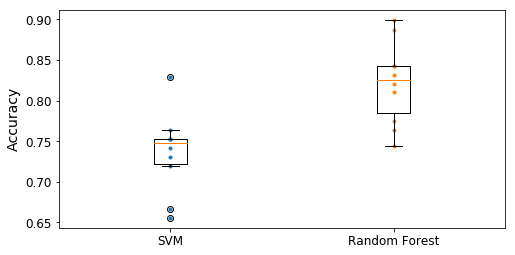

In [196]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_distribs = {
        'max_features': sp_randint(1, 10),
        'n_estimators': sp_randint(10, 100),
    }


param_grid = [
    {'n_estimators': [5000], 'max_features':[5]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]

rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                verbose=3, n_jobs=4, random_state=42)

rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0E475F70>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0E475F10>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [205]:
rnd_search.best_params_  

{'max_features': 7, 'n_estimators': 61}

In [206]:
rnd_search.best_score_ 

-0.18069584736251404

In [210]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.24530504, 0.04482151, 0.02824513, 0.2423483 , 0.02603153,
       0.01207796, 0.06349065, 0.16840572, 0.13284458, 0.01205843,
       0.00745921, 0.01691194])

In [211]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = preprocess_pipeline.named_transformers_["cat_pipeline"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

AttributeError: 'FeatureUnion' object has no attribute 'named_transformers_'

In [201]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10, n_jobs=-1)
forest_scores.mean()

0.8217200090795597